### Import libraries

In [74]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pandas import DataFrame
from keras import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose

### Utility functions 

In [75]:

def split_train_validate_test(df: DataFrame, train_percent=.6, validate_percent=.2, test_percent=.2):
    """
    Splits the given DataFrame into training, validation, and testing datasets based on the specified percentages.

    Parameters:
    df (DataFrame): The input DataFrame to be split.
    train_percent (float): The percentage of data to be used for training. Default is 0.6 (60%).
    validate_percent (float): The percentage of data to be used for validation. Default is 0.2 (20%).
    test_percent (float): The percentage of data to be used for testing. Default is 0.2 (20%).

    Returns:
    tuple: A tuple containing three DataFrames - (train, validate, test).
    """
    df.sort_values(by="Date", inplace=True) 
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    
    return train, validate, test

def plot_history(history):
    """
    Plots the training and validation metrics (MAE and MSE) over epochs from the given training history.

    Parameters:
    history (keras.callbacks.History): The history object returned by the `fit` method of a Keras model.

    Description:
    - This function extracts the training and validation metrics (Mean Absolute Error and Mean Squared Error) 
      from the history object and visualizes them using line plots.
    - The first plot shows the Mean Absolute Error (MAE) for both training and validation over epochs.
    - The second plot shows the Mean Squared Error (MSE) for both training and validation over epochs.

    Returns:
    None
    """
    history_dict = history.history

    # MAE
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 1, 1)
    plt.plot(history_dict['mae'], label='Training MAE')
    plt.plot(history_dict['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)

    # MSE
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['mse'], label='Training MSE')
    plt.plot(history_dict['val_mse'], label='Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def load_data():
    df = pd.read_csv('./training_data/GBPUSD_open_5year.csv')
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
    df.sort_values(by="Date", inplace=True)
    return df


def plot_gbp_usd(data):
    """
    Plots the GBP/USD exchange rate for multiple datasets.

    Parameters:
    data (list): A list of datasets, where each dataset is a tuple containing:
                 - dates (array-like): The dates for the data points.
                 - prices (array-like): The corresponding GBP/USD prices.
                 - label (list): A list containing a single label for the dataset.

    Description:
    - Iterates through the datasets and plots the GBP/USD prices against their dates.
    - Uses distinct colors for each dataset and adds a legend for clarity.
    - Formats the x-axis with quarterly ticks and rotates them for better readability.

    Returns:
    None
    """
    plt.figure(figsize=(14, 7))
    plt.title('GBPUSD Exchange Rate')
    plt.ylabel('Price GBP-USD')

    colors = plt.cm.tab10.colors  # Use a colormap for distinct colors

    # Iterate through each dataset in the array
    for idx, dataset in enumerate(data):
        dates = dataset[0]
        prices = dataset[1]
        label = data[idx][2]
        plt.plot(dates, prices, label=f'{label}', color=colors[idx % len(colors)], alpha=0.7)

    plt.xticks(pd.date_range(start=min(dates), end=max(dates), freq='3MS'), rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

def pre_process_data(df: DataFrame):
    """
    Pre-processes the given DataFrame by decomposing the 'Open' column into trend, seasonality, and noise components.
    Additionally, it extracts temporal features such as week, month, and day.

    Parameters:
    df (DataFrame): The input DataFrame containing a 'Date' column and an 'Open' column.

    Returns:
    DataFrame: The modified DataFrame with added columns for trend, seasonality, noise, week, month, and day.
    """
    # Decompose the 'Open' column into trend, seasonality, and noise
    decomp = seasonal_decompose(df["Open"], model='additive', period=30)  # Adjust period based on seasonality
    df["Trend"] = decomp.trend.bfill().ffill()
    df["Seasonality"] = decomp.seasonal.bfill().ffill()
    df["Noise"] = decomp.resid.bfill().ffill()

    # Extract temporal features
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day

    return df

def plot_pre_processed_data(df: DataFrame):
    """
    Plots the decomposed components (Trend, Seasonality, Noise) of the given DataFrame along with the original data.

    Parameters:
    df (DataFrame): The input DataFrame containing 'Date', 'Open', 'Trend', 'Seasonality', and 'Noise' columns.

    Description:
    - This function creates a multi-panel plot to visualize the original data and its decomposed components.
    - Each subplot corresponds to one of the components or the original data.

    Returns:
    None
    """
    # Plot the decomposed components
    plt.figure(figsize=(14, 10))

    # Plot the original data
    plt.subplot(4, 1, 1)
    plt.plot(df["Date"], df["Open"], label="Original", color="blue")
    plt.title("Original Data")
    plt.legend()

    # Plot the trend
    plt.subplot(4, 1, 2)
    plt.plot(df["Date"], df["Trend"], label="Trend", color="orange")
    plt.title("Trend")
    plt.legend()

    # Plot the seasonality
    plt.subplot(4, 1, 3)
    plt.plot(df["Date"], df["Seasonality"], label="Seasonality", color="green")
    plt.title("Seasonality")
    plt.legend()

    # Plot the noise
    plt.subplot(4, 1, 4)
    plt.plot(df["Date"], df["Noise"], label="Noise", color="red")
    plt.title("Noise")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_train_val_evaluation_history(t, v, type="MAE"):
    """
    Plots the training and validation evaluation history for a given metric type.

    Parameters:
    t (list): Training metric values over epochs.
    v (list): Validation metric values over epochs.
    type (str): The type of metric to plot. Default is "MAE". Options are "MAE" or "MSE".

    Description:
    - This function creates a line plot comparing the training and validation metric values over epochs.
    - The x-axis represents the epochs, and the y-axis represents the metric values.
    - The plot includes a legend to distinguish between training and validation metrics.

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    plt.plot(t, label=f'Training {type}', color='blue')
    plt.plot(v, label=f'Validation {type}', color='orange')
    plt.title(f"Training and Validation {type}")
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean {"Absolute" if type == "MAE" else "Squared"} Error ({type})')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_evaluation_metrics(y_true, y_pred):
    """
    Prints evaluation metrics for the given true and predicted values.

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    dict: A dictionary containing the calculated metrics (MAE, MSE, R^2, MAPE).
    """
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true.values - y_pred.flatten()) / y_true.values)) * 100
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    return {"MAE": mae, "MSE": mse, "R Square": r2, "MAPE": mape}

def time_sequence_generator(feature, target, time_step):
    """
    Generates sequences of features and corresponding targets for time series data.

    Parameters:
    feature (array-like): The input features for the time series.
    target (array-like): The target values corresponding to the features.
    time_step (int): The number of time steps to include in each sequence.

    Returns:
    tuple: A tuple containing two numpy arrays:
           - X: The generated feature sequences of shape (n_samples, time_step, n_features).
           - y: The corresponding target values of shape (n_samples,).
    """
    X = []
    y = []
    # Iterate over data to create sequences
    for i in range(time_step, len(feature)):
        X.append(feature[i - time_step:i])  
        y.append(target[i])  
    
    return np.array(X), np.array(y)

# 1. Visualize the data

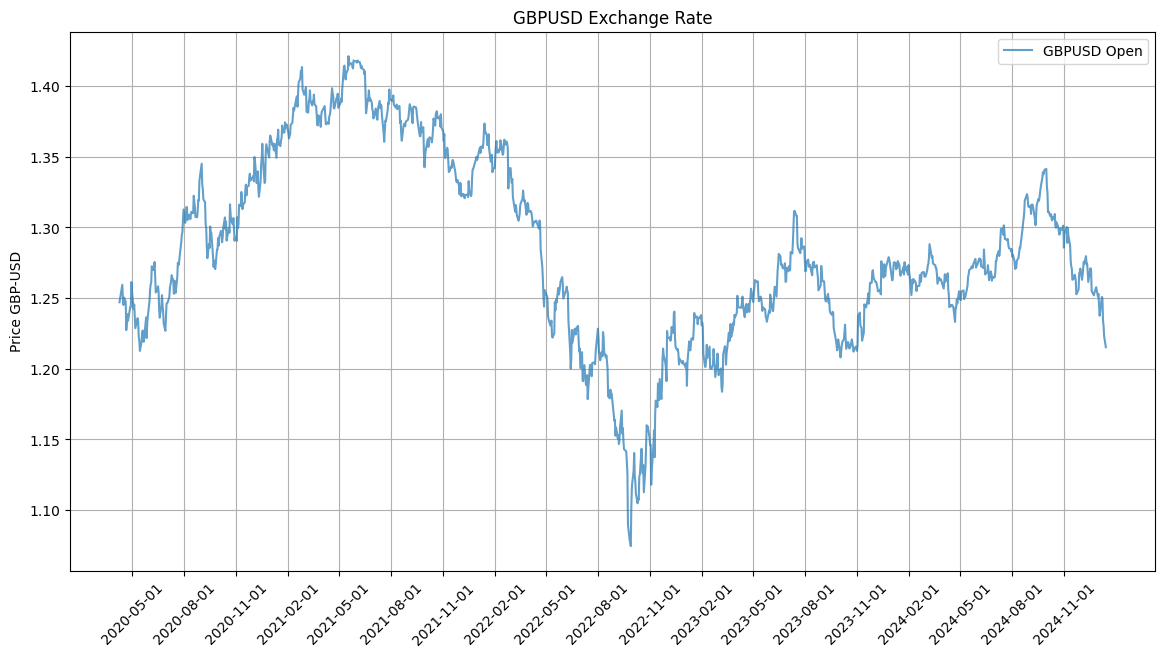

In [76]:
data = load_data()
plot_gbp_usd([[data['Date'], data['Open'], "GBPUSD Open"]])

# 2. Pre-process the data
Dissect temporal information like Trend, Seasonality, Noise, Day, Week & Month   

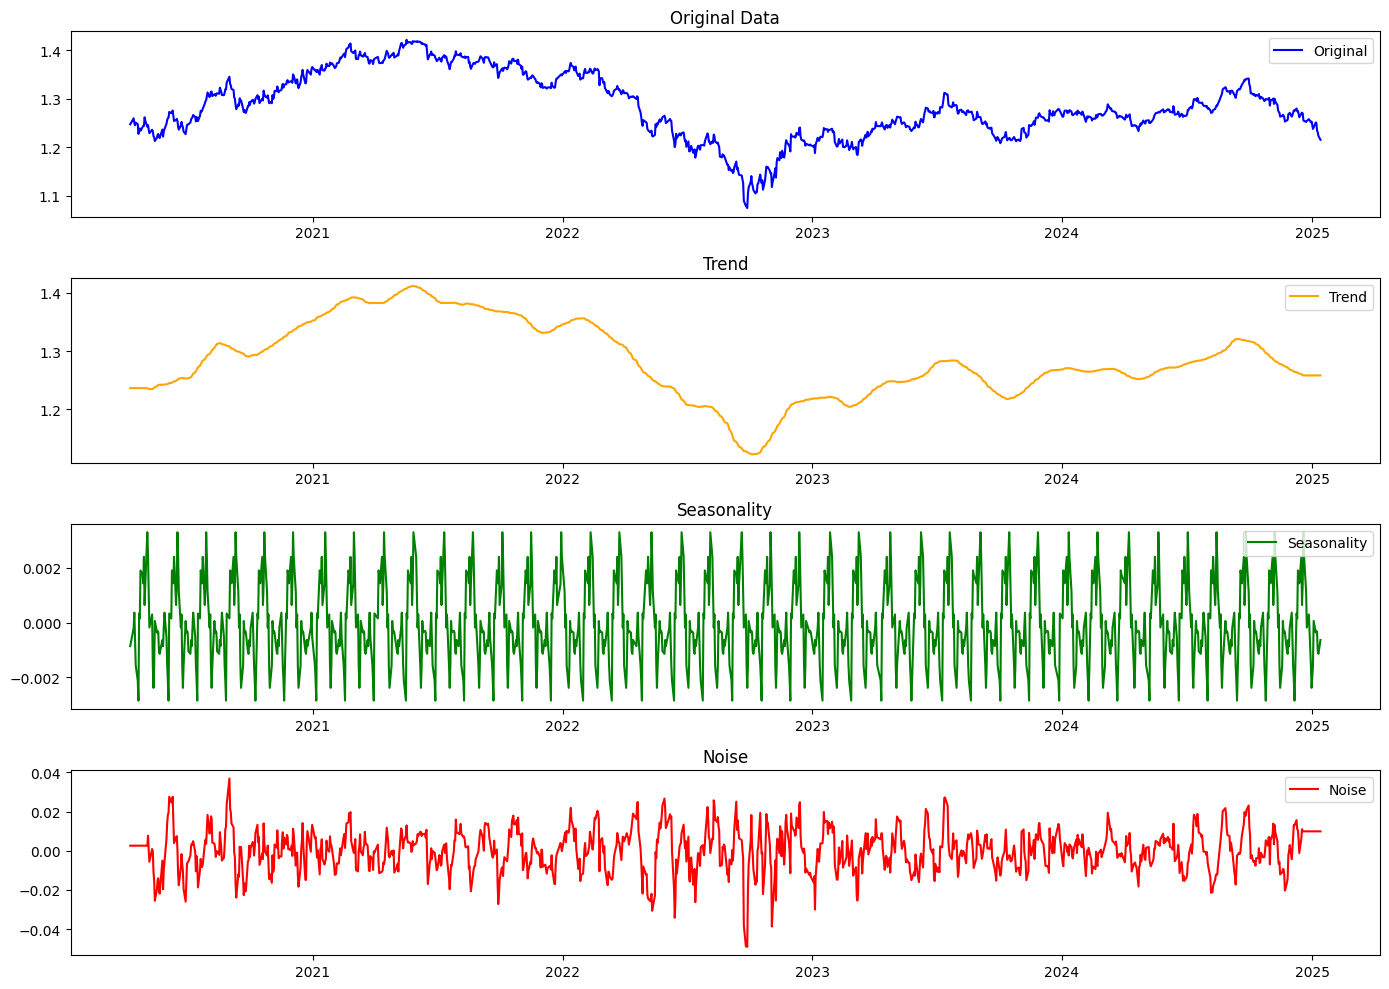

In [77]:
# General pre-process data for overall models
df = load_data()
df = pre_process_data(df)
plot_pre_processed_data(df)


# 3. Model based on each time instance

### 3.1 Split the Test, validate and Train data 


In [78]:
# Training  and Target Features
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day']
target = "Open"

# Split data 
u_train, u_validate, u_test = split_train_validate_test(df, train_percent=.7, validate_percent=0.15, test_percent=.15)

### 3.2 Scale the features and target

In [79]:
# Normalize data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale train, validate, and test sets
# Feature and target scaling on Training data 
train = pd.DataFrame()
feature_scaler.fit_transform(u_train[features])
target_scaler.fit_transform(u_train[[target]])

train['Date'] = u_train['Date']
train[features] = feature_scaler.transform(u_train[features])
train[target] = target_scaler.transform(u_train[[target]])

validate = pd.DataFrame()
validate['Date'] = u_validate['Date']
validate[features] = feature_scaler.transform(u_validate[features])
validate[target] = target_scaler.transform(u_validate[[target]])

test = pd.DataFrame()
test['Date'] = u_test['Date']
test[features] = feature_scaler.transform(u_test[features])
test[target] = target_scaler.transform(u_test[[target]])


### 3.3 Develop a base model

In [107]:
# Define the model
base_dnn_model = Sequential([
	layers.Dense(64, activation='relu', input_shape=(len(features),)),
	# layers.Dense(128, activation='relu'),
	layers.Dense(1)  # Output layer for regression
])

# Compile the model
base_dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

base_dnn_history = base_dnn_model.fit(train[features], train[target], epochs=10, batch_size=1, validation_data=(validate[features], validate[target]))


Epoch 1/10


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


840/840 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - loss: 0.0192 - mae: 0.0723 - mse: 0.0192 - val_loss: 6.1028e-05 - val_mae: 0.0068 - val_mse: 6.1028e-05
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 5.8131e-05 - mae: 0.0054 - mse: 5.8131e-05 - val_loss: 3.4843e-05 - val_mae: 0.0057 - val_mse: 3.4843e-05
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 3.9014e-05 - mae: 0.0042 - mse: 3.9014e-05 - val_loss: 3.6384e-06 - val_mae: 0.0013 - val_mse: 3.6384e-06
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 3.6564e-05 - mae: 0.0038 - mse: 3.6564e-05 - val_loss: 1.9475e-06 - val_mae: 0.0010 - val_mse: 1.9475e-06
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 4.5028e-05 - mae: 0.0046 - mse: 4.5028e-05 - val_loss: 1.7494e-06 - val_mae: 0.0011 - val_mse: 1.7494e-06
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 4.2312e-05 - mae: 0.0042 - mse: 4.2312e-05 - val_loss: 3.5833e-06 - val_mae: 0.0015 - val_mse: 3.5833e-06
Epoch 7/10


### 3.4 Base model evaluation 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
Mean Absolute Error (MAE): 0.001
Mean Squared Error (MSE): 0.000
R^2 Score: 0.999
Mean Absolute Percentage Error (MAPE): 0.113%


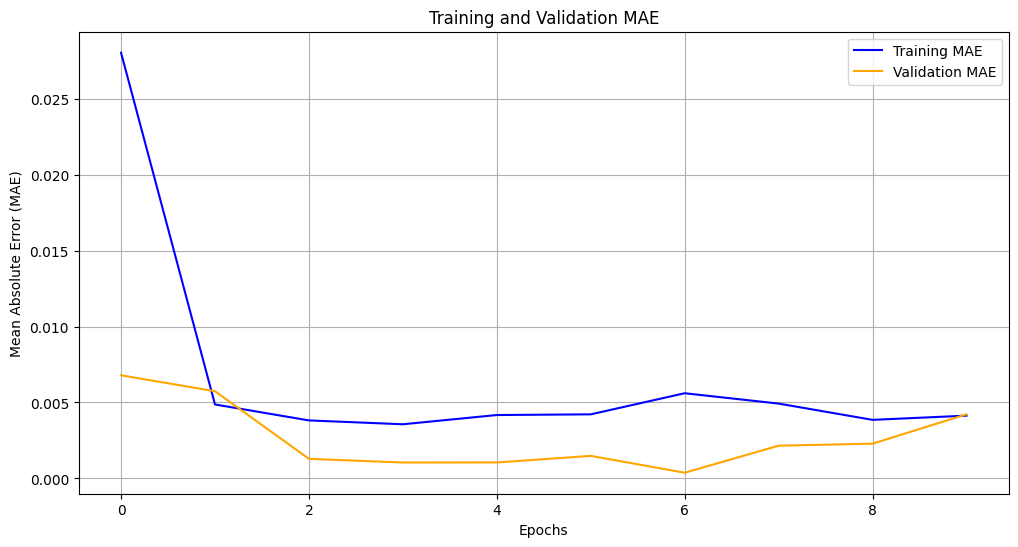

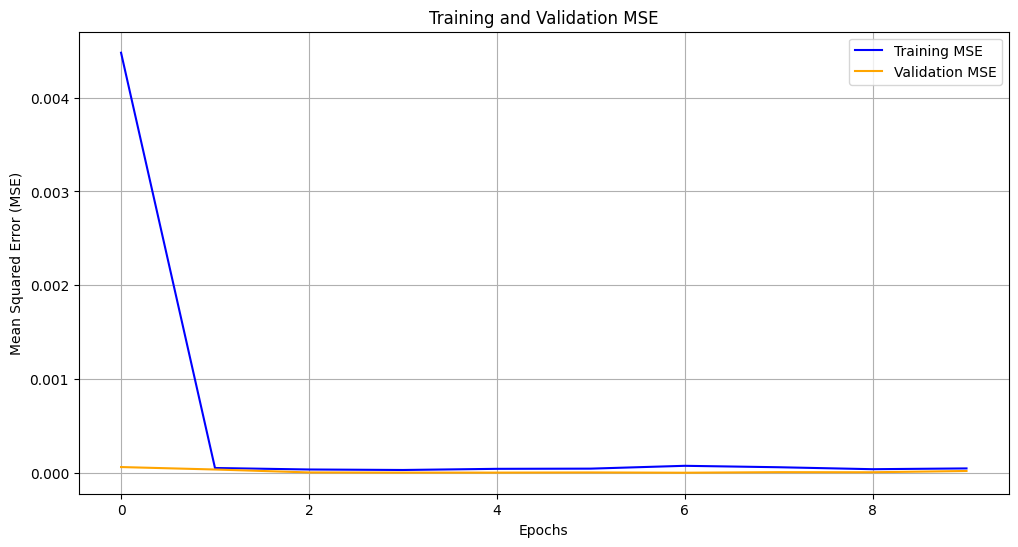

In [108]:
history = base_dnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

# Inverse transform before evaluation
y_true_orig = target_scaler.inverse_transform(train[[target]])
y_pred_orig = target_scaler.inverse_transform(base_dnn_model.predict(train[features]))

print_evaluation_metrics(pd.Series(y_true_orig.flatten()), y_pred_orig.flatten())


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")
            
# print_evaluation_metrics(train[target], base_dnn_model.predict(train[features]))            


### 3.5 Hyper-tuning

In [109]:
#build model
def build_model(hp):
    model = Sequential()
    num_layers_params = hp.Int('num_layers', 2, 4, step=5)

    i = 0
    unit_params = hp.Int(f'units_{i}', min_value=64, max_value=128, step=32)
    model.add(layers.Dense(units=unit_params, activation="relu", input_dim=len(features)))
    for i in range(1, num_layers_params):  
        model.add(layers.Dense(units=unit_params, activation='relu'))

    model.add(layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

    return model

tuner = kt.Hyperband(build_model, objective='val_mse', factor=3, directory='nn_cache', project_name='DNN_tuning')
tuner.search(train[features],train[target],  epochs=50, validation_data=(validate[features], validate[target]), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_dict = best_hps.values
best_hps_df = pd.DataFrame(list(best_hps_dict.items()), columns=['Hyperparameter', 'Value'])
best_hps_df

Reloading Tuner from nn_cache/DNN_tuning/tuner0.json


,Hyperparameter,Value
0,num_layers,2
1,units_0,96
2,tuner/epochs,2
3,tuner/initial_epoch,0
4,tuner/bracket,4
5,tuner/round,0


### 3.6 Evaluate hyper-tuned model 

Epoch 1/10


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3349 - mae: 0.4800 - mse: 0.3349 - val_loss: 0.0257 - val_mae: 0.1441 - val_mse: 0.0257
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0134 - mae: 0.0916 - mse: 0.0134 - val_loss: 0.0028 - val_mae: 0.0467 - val_mse: 0.0028
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - mae: 0.0389 - mse: 0.0024 - val_loss: 7.4426e-04 - val_mae: 0.0221 - val_mse: 7.4426e-04
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0619e-04 - mae: 0.0207 - mse: 7.0619e-04 - val_loss: 4.3445e-04 - val_mae: 0.0172 - val_mse: 4.3445e-04
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1628e-04 - mae: 0.0172 - mse: 5.1628e-04 - val_loss: 3.4056e-04 - val_mae: 0.0153 - val_mse: 3.4056e-04
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1913e-04 - mae: 0.0136 - mse: 3.1913e-04 - val_loss: 2.1201e-04 - val_mae: 0.0120 - val_mse: 2.1201e-04
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8477e-0

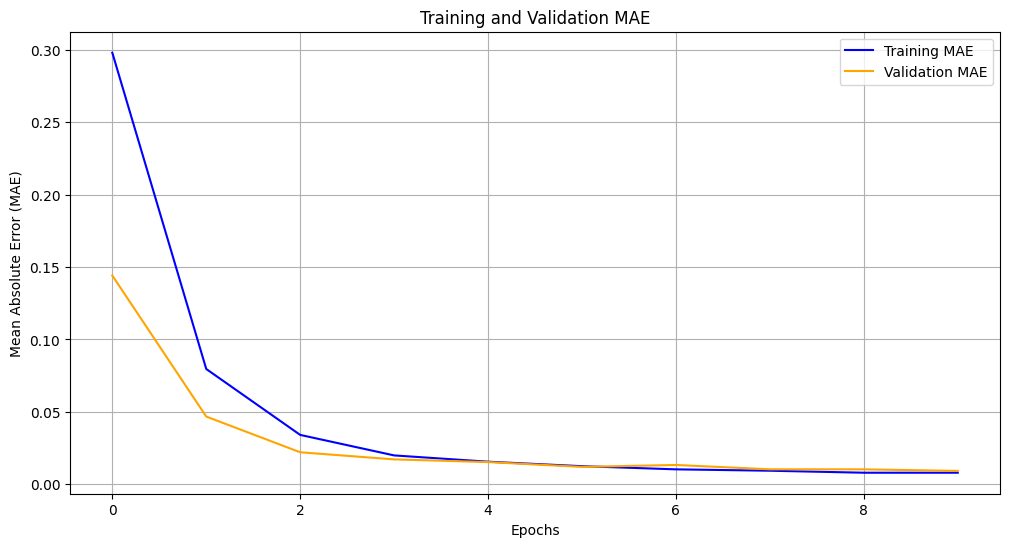

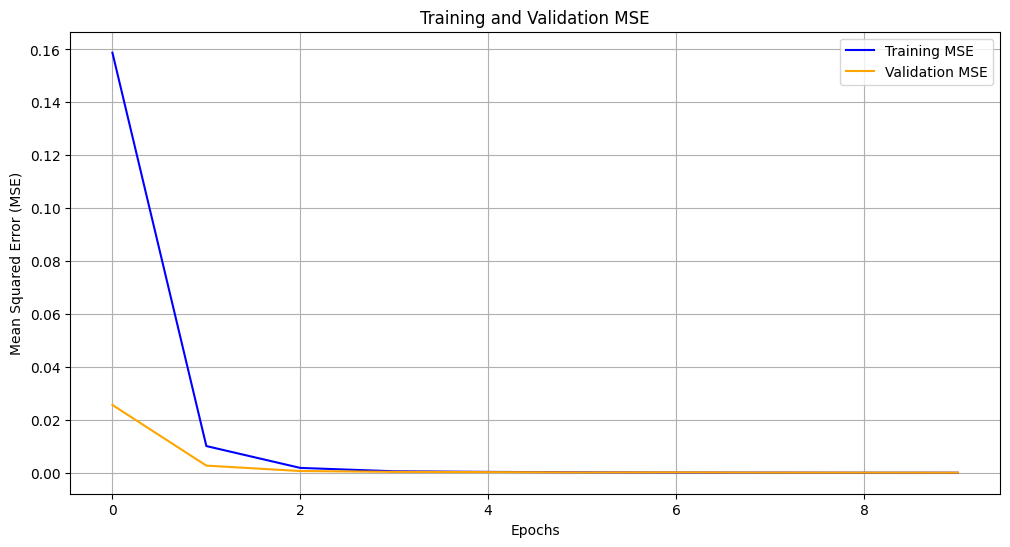

Mean Absolute Error (MAE): 0.011
Mean Squared Error (MSE): 0.001
R^2 Score: 0.886
Mean Absolute Percentage Error (MAPE): 2.130%


In [83]:

# Train the model with the best hyperparameters
dnn_model = build_model(best_hps)
history = dnn_model.fit(train[features], train[target], epochs=10, validation_data=(validate[features], validate[target]))

# Extract training and validation metrics
train_mae = history.history['mae']
train_mse = history.history['mse']
val_mae = history.history['val_mae']
val_mse = history.history['val_mse']

# Get model predictions on Test Data
y_pred = base_dnn_model.predict(test[features])
y_true = test[target]

# Plot the training and validation MAE and MSE 
plot_train_val_evaluation_history(train_mae, val_mae, "MAE")
plot_train_val_evaluation_history(train_mse, val_mse, "MSE")

# Print Evaluation Metrics
dnn_metric =  print_evaluation_metrics(y_true, y_pred)

### 3.7 Overview of whole predicted model 

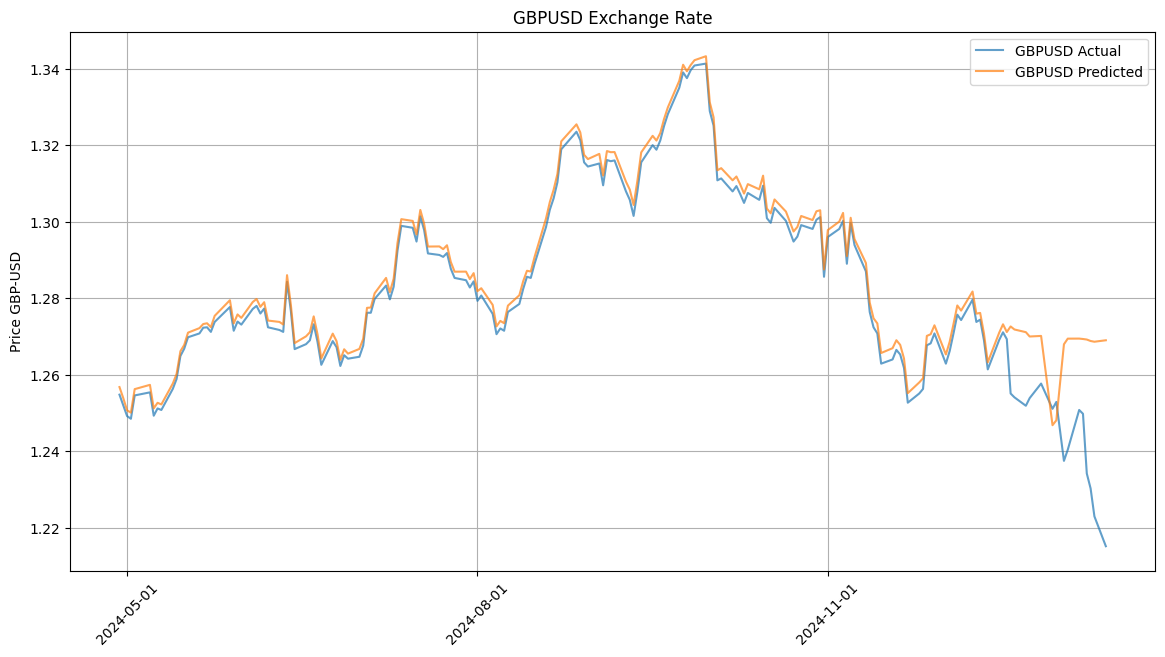

In [84]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values

actual_data = [test["Date"], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"], y_pred_unscaled, "GBPUSD Predicted"]

dnn_predicted = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 4 LSTM Neural Network (Time Series)

### 4.1 Implementing scaler on dataset

In [85]:
# Update the features as working with sequence data, its better to use previous open price as a feature
# Scaling the feature with updated scaler
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']
features = ['Trend', 'Seasonality', 'Noise', 'Open']
feature_scaler = MinMaxScaler()
feature_scaler.fit(u_train[features])

# Creating a scaled dataframe
scaled_df = pd.DataFrame()

# Implementing Scaler on whole data  
scaled_df['Date'] = df['Date']
scaled_df[features] = feature_scaler.transform(df[features])
scaled_df[target] = target_scaler.transform(df[[target]])

### 4.2 Splitting & Generate Sequence

In [86]:
SEQ_LENGTH = 7

# Splitting the scaled data into train, validate, and test sets
train, validate, test = split_train_validate_test(scaled_df, train_percent=.7, validate_percent=0.15, test_percent=.15)
print(train)

train_feature_seq, train_target_seq = time_sequence_generator(
    train[features].values, 
    train[target].values, 
    SEQ_LENGTH
)

validation_feature_seq, validation_target_seq = time_sequence_generator(
    validate[features].values, 
    validate[target].values, 
    SEQ_LENGTH)

test_feature_seq, test_target_seq = time_sequence_generator(
    test[features].values, 
    test[target].values, 
    SEQ_LENGTH
)

print(test_feature_seq.shape, test_target_seq.shape)

          Date     Trend  Seasonality     Noise      Open
0   2020-04-09  0.393619     0.323546  0.601015  0.497692
1   2020-04-14  0.393619     0.432098  0.601015  0.533468
2   2020-04-15  0.393619     0.522537  0.601015  0.505770
3   2020-04-16  0.393619     0.377117  0.601015  0.492210
4   2020-04-17  0.393619     0.210004  0.601015  0.507501
..         ...       ...          ...       ...       ...
835 2023-08-04  0.541817     0.414602  0.534294  0.580496
836 2023-08-07  0.535748     0.403909  0.572970  0.584824
837 2023-08-08  0.530875     0.292925  0.539162  0.570398
838 2023-08-09  0.527619     0.277965  0.562843  0.573283
839 2023-08-10  0.525065     0.360066  0.569068  0.574149

[840 rows x 5 columns]
(173, 7, 4) (173,)


### 4.3 Train base model

In [87]:
lstm_base_model = Sequential([
    layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])

lstm_base_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

base_lstm_history = lstm_base_model.fit(test_feature_seq, test_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

Epoch 1/50


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3484 - mae: 0.5861 - mse: 0.3484 - val_loss: 0.1668 - val_mae: 0.4050 - val_mse: 0.1668
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2121 - mae: 0.4544 - mse: 0.2121 - val_loss: 0.0631 - val_mae: 0.2469 - val_mse: 0.0631
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0743 - mae: 0.2606 - mse: 0.0743 - val_loss: 0.0023 - val_mae: 0.0373 - val_mse: 0.0023
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 - mae: 0.0796 - mse: 0.0110 - val_loss: 0.0339 - val_mae: 0.1770 - val_mse: 0.0339
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0190 - mae: 0.1196 - mse: 0.0190 - val_loss: 0.0033 - val_mae: 0.0448 - val_mse: 0.0033
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - mae: 0.0540 - mse: 0.0043 - val_loss: 0.0024 - val_mae: 0.0414 - val_mse: 0.0024
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - mae: 0.0774 - mse: 0.0078 - val_loss: 0.0017 - val_mae: 0.0323 - val_

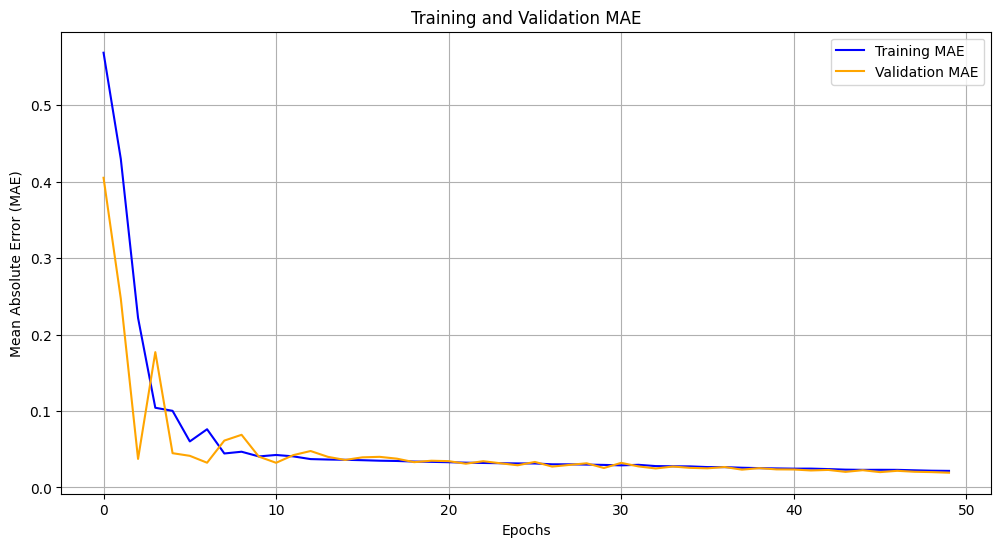

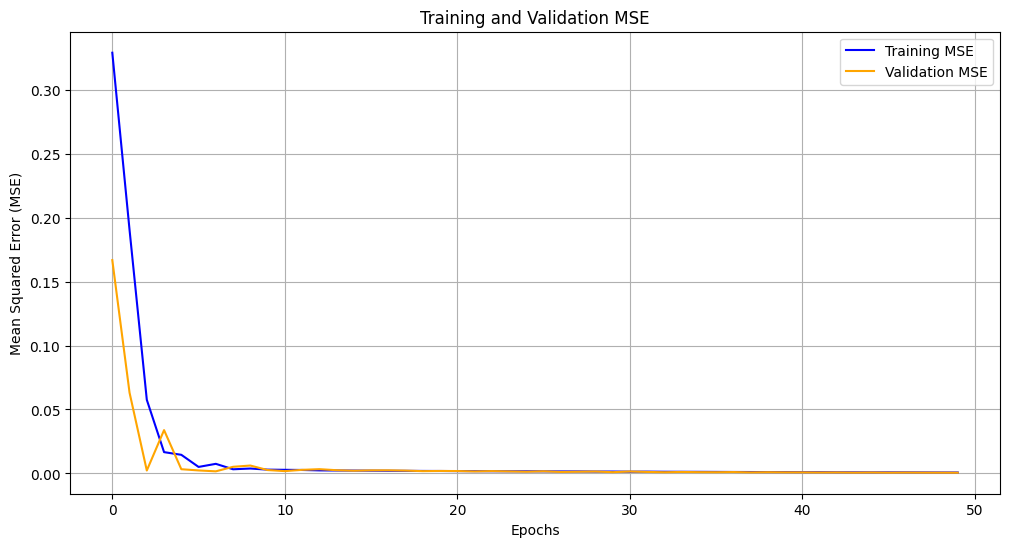

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Mean Absolute Error (MAE): 0.021
Mean Squared Error (MSE): 0.001
R^2 Score: 0.847
Mean Absolute Percentage Error (MAPE): 12.114%


In [88]:
history = base_lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
base_lstm_metric =  print_evaluation_metrics(y_true, y_pred)

### 4.4 Hyper-tune LSTM

In [89]:
import keras_tuner as kt # type: ignore

TIME_STEP = 3

def build_model(hp):
    model = keras.Sequential()


    # Adding LSTM layers
    for i in range(4):  # 3 LSTM layers
        model.add(layers.LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None,
            activation="relu",
            return_sequences=i < 3,
        ))

    # Output layer
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1))

    # Tuning learning rate

    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae', 'mse']
    )

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=25,
    factor=12,
    directory='nn_cache',
    project_name='LSTM_tuning',
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor='val_mae'
)

# Hyperparameter search
tuner.search(
    train_feature_seq, train_target_seq,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(validation_feature_seq, validation_target_seq),
    batch_size=12,
    verbose=1
)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/LSTM_tuning/tuner0.json


### 4.5 Build Hyper-tuned LSTM Model

In [90]:
print(train_feature_seq.shape, train_target_seq.shape, validation_feature_seq.shape, validation_target_seq.shape)
lstm_model = tuner.hypermodel.build(best_hps)
lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
lstm_history = lstm_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
)

(833, 7, 4) (833,) (173, 7, 4) (173,)
Epoch 1/100


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4201 - mae: 0.4201 - mse: 0.2468 - val_loss: 0.0571 - val_mae: 0.0571 - val_mse: 0.0044
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0743 - mae: 0.0743 - mse: 0.0087 - val_loss: 0.0280 - val_mae: 0.0280 - val_mse: 0.0012
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0587 - mae: 0.0587 - mse: 0.0056 - val_loss: 0.0225 - val_mae: 0.0225 - val_mse: 7.8872e-04
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0602 - mae: 0.0602 - mse: 0.0056 - val_loss: 0.0292 - val_mae: 0.0292 - val_mse: 0.0013
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0660 - mae: 0.0660 - mse: 0.0070 - val_loss: 0.0364 - val_mae: 0.0364 - val_mse: 0.0018
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0603 - mae: 0.0603 - mse: 0.0057 - val_loss: 0.0260 - val_mae: 0.0260 - val_mse: 9.8023e-04
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0491 - mae: 0.0491 - mse: 0.0038 - val_loss: 0.0

### 4.6 Evaluate the Hyper-tuned Data 

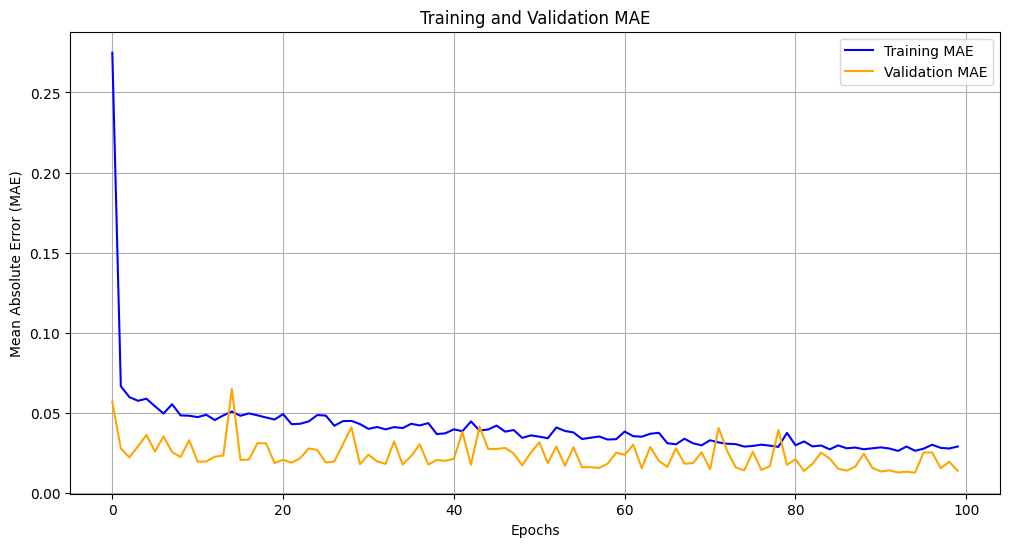

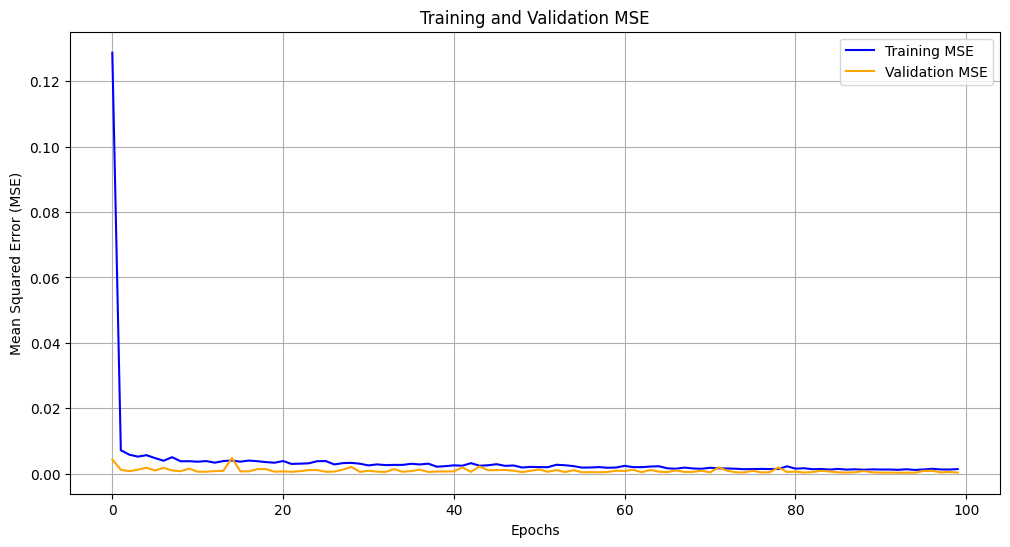

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Mean Absolute Error (MAE): 0.016
Mean Squared Error (MSE): 0.001
R^2 Score: 0.891
Mean Absolute Percentage Error (MAPE): 12.518%


In [91]:
history = lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
lstm_metric =  print_evaluation_metrics(y_true, y_pred)

lstm_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

### Plot the Actual, Predicted Value 

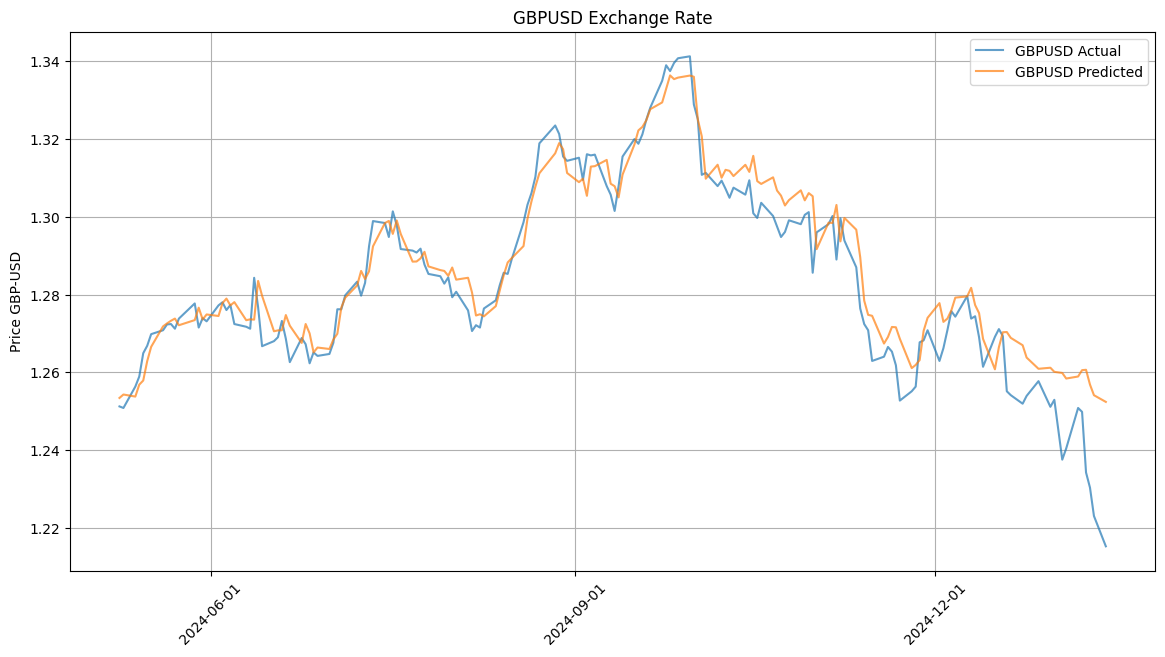

In [92]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

lstm_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 5. Recurrent Model

### 5.1 Build base model

In [93]:
rnn_base_model = Sequential()
rnn_base_model.add(layers.SimpleRNN(units=64, activation='relu', input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
rnn_base_model.add(layers.Dense(1))
    
rnn_base_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

rnn_base_history = rnn_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

Epoch 1/50


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2723 - mae: 0.4244 - mse: 0.2723 - val_loss: 0.0046 - val_mae: 0.0563 - val_mse: 0.0046
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - mae: 0.0942 - mse: 0.0139 - val_loss: 0.0016 - val_mae: 0.0304 - val_mse: 0.0016
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0463 - mse: 0.0035 - val_loss: 0.0014 - val_mae: 0.0295 - val_mse: 0.0014
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mae: 0.0323 - mse: 0.0017 - val_loss: 7.6987e-04 - val_mae: 0.0217 - val_mse: 7.6987e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - mae: 0.0283 - mse: 0.0013 - val_loss: 6.6225e-04 - val_mae: 0.0201 - val_mse: 6.6225e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mae: 0.0263 - mse: 0.0012 - val_loss: 5.3972e-04 - val_mae: 0.0181 - val_mse: 5.3972e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7826e-04 - mae: 0.0228 - mse: 8.7826e-0

### 5.2 Evaluate base model 

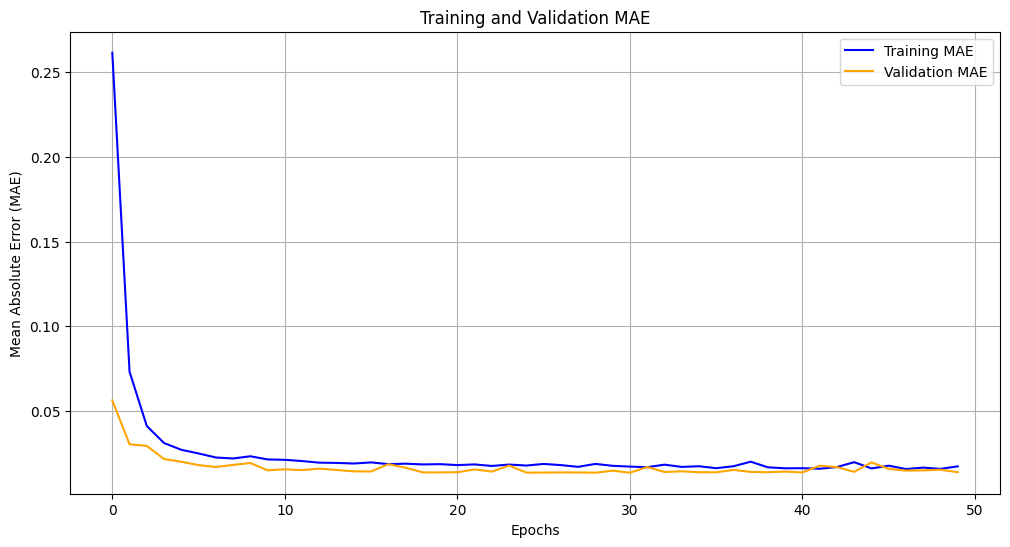

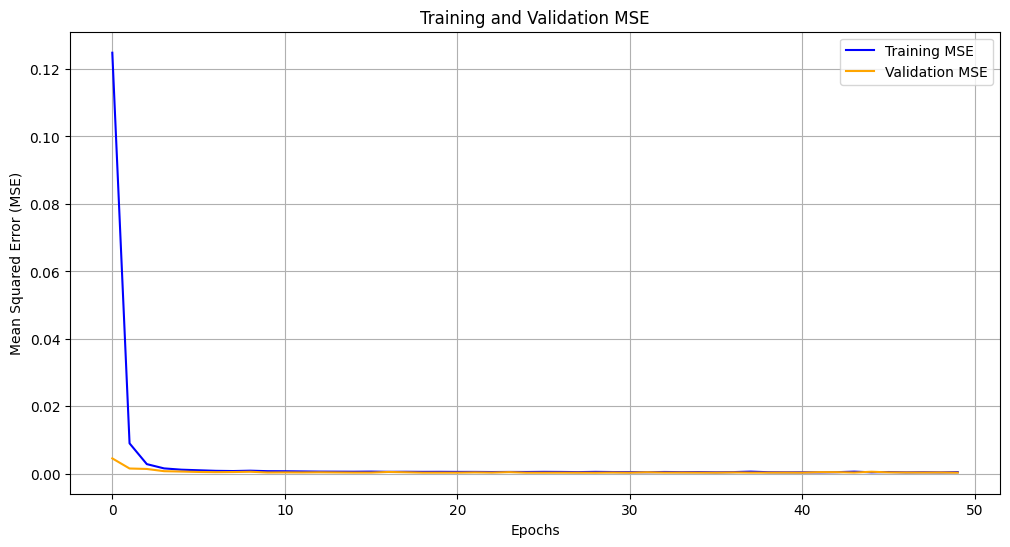

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Mean Absolute Error (MAE): 0.016
Mean Squared Error (MSE): 0.001
R^2 Score: 0.893
Mean Absolute Percentage Error (MAPE): 12.436%


In [94]:
history = rnn_base_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_base_metric = print_evaluation_metrics(y_true, y_pred)

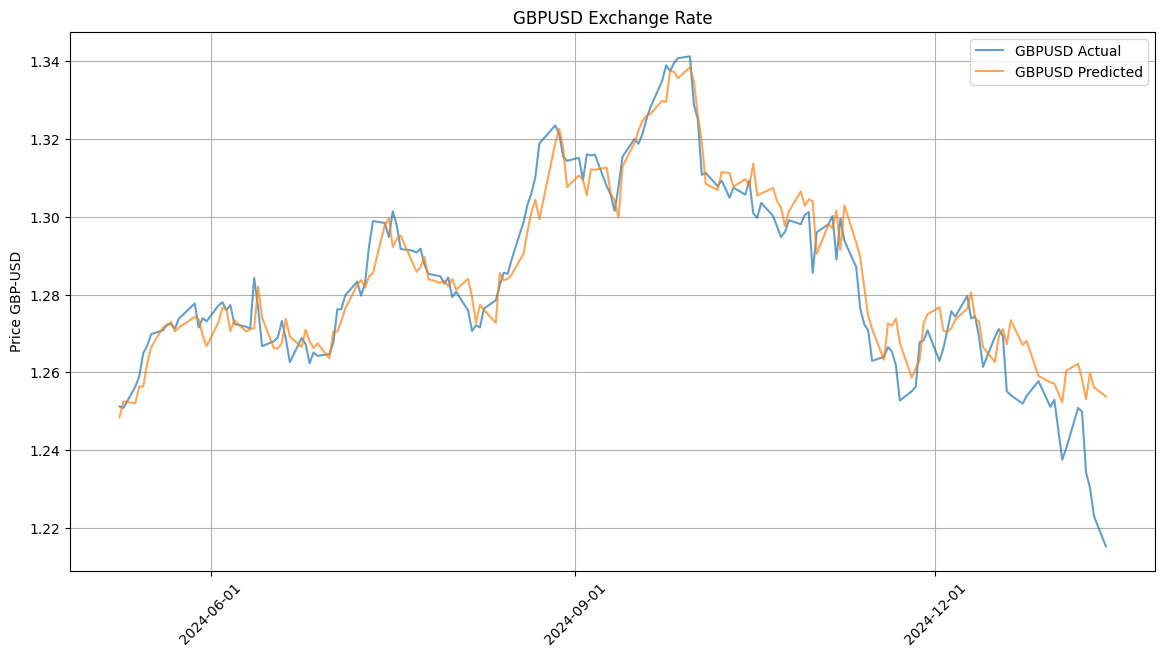

In [95]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

rnn_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

### 5.3 Hyper-tune RNN model

In [96]:
# Build RNN model
def build_model(hp):
	model = Sequential()
	num_layers = hp.Int('num_layers', min_value=1, max_value=4)
	for i in range(num_layers):
		model.add(layers.SimpleRNN(
			units=hp.Int(f'units_{i}', min_value=16, max_value=62, step=16),
			activation='relu',
			return_sequences=(i != num_layers - 1),
			input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None
		))
		model.add(layers.Dropout(0.1))
	
	model.add(layers.Dense(units=1))  # Output layer

	model.compile(
		optimizer=tf.keras.optimizers.Adam(
			learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
		),
		loss='mean_squared_error',
		metrics=['mae', 'mse']
	)
	return model

# Hyperband tuner
tuner = kt.Hyperband(
	build_model,
	objective='val_loss',
	max_epochs=25,
	factor=3,
	directory='nn_cache',
	project_name='RNN'
)

# Search for the best hyperparameters
tuner.search(train_feature_seq, train_target_seq, epochs=50, validation_data=(validation_feature_seq, validation_target_seq), batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

Reloading Tuner from nn_cache/RNN/tuner0.json


{'num_layers': 1,
 'units_0': 32,
 'learning_rate': 0.009021221727276136,
 'units_1': 48,
 'units_2': 48,
 'units_3': 16,
 'tuner/epochs': 25,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

### 5.4 Build Hyper-tune model 

In [97]:
rnn_model = tuner.hypermodel.build(best_hps)
rnn_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
rnn_history = rnn_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=50,
    validation_data=(validation_feature_seq, validation_target_seq),
)

Epoch 1/100


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2250 - mae: 0.2250 - mse: 0.0929 - val_loss: 0.0731 - val_mae: 0.0731 - val_mse: 0.0078
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1314 - mae: 0.1314 - mse: 0.0310 - val_loss: 0.0638 - val_mae: 0.0638 - val_mse: 0.0053
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1171 - mae: 0.1171 - mse: 0.0236 - val_loss: 0.0550 - val_mae: 0.0550 - val_mse: 0.0037
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1014 - mae: 0.1014 - mse: 0.0192 - val_loss: 0.0260 - val_mae: 0.0260 - val_mse: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0962 - mae: 0.0962 - mse: 0.0175 - val_loss: 0.0270 - val_mae: 0.0270 - val_mse: 0.0011
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0916 - mae: 0.0916 - mse: 0.0150 - val_loss: 0.0203 - val_mae: 0.0203 - val_mse: 6.6647e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0819 - mae: 0.0819 - mse: 0.0117 - val_loss: 0.0305 -

### 5.4 Evaluate Hyper-tuned model

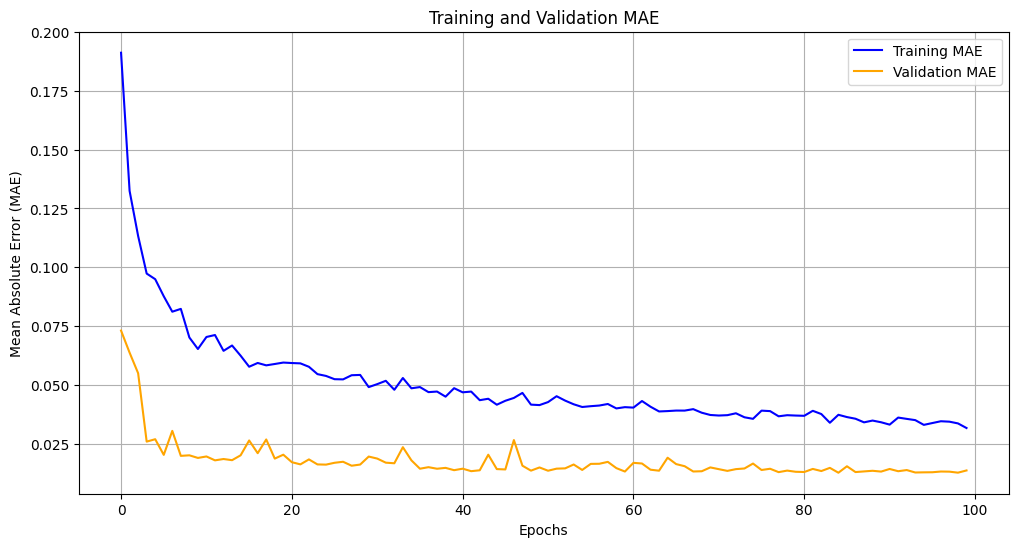

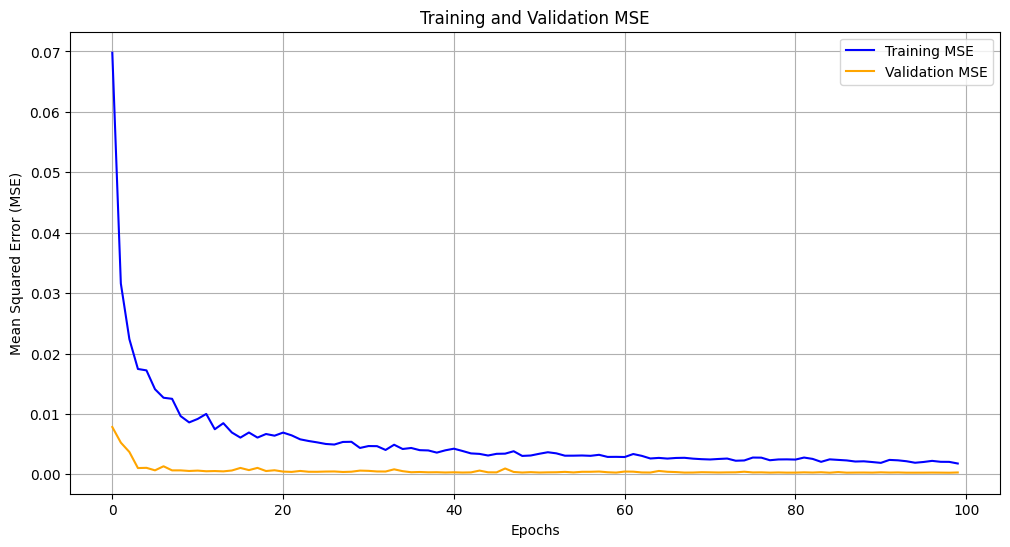

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Mean Absolute Error (MAE): 0.016
Mean Squared Error (MSE): 0.000
R^2 Score: 0.918
Mean Absolute Percentage Error (MAPE): 12.356%


In [98]:
history = rnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_metric =  print_evaluation_metrics(y_true, y_pred)


rnn_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

# 6. CNN_LSTM Model

### 6.1 Develop Base Model

In [99]:
cl_base_model = keras.Sequential()

cl_base_model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
cl_base_model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cl_base_model.add(layers.LSTM(units=64, return_sequences=False))
cl_base_model.add(layers.Dense(units=1, activation='linear'))
cl_base_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

cl_base_history = cl_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2016 - mae: 0.3690 - mse: 0.2016 - val_loss: 0.0020 - val_mae: 0.0362 - val_mse: 0.0020
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - mae: 0.0898 - mse: 0.0120 - val_loss: 0.0028 - val_mae: 0.0461 - val_mse: 0.0028
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mae: 0.0461 - mse: 0.0033 - val_loss: 0.0016 - val_mae: 0.0345 - val_mse: 0.0016
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mae: 0.0323 - mse: 0.0018 - val_loss: 9.7802e-04 - val_mae: 0.0254 - val_mse: 9.7802e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mae: 0.0280 - mse: 0.0014 - val_loss: 6.8119e-04 - val_mae: 0.0210 - val_mse: 6.8119e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mae: 0.0251 - mse: 0.0011 - val_loss: 5.7547e-04 - val_mae: 0.0191 - val_mse: 5.7547e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mae: 0.0260 - mse: 0.

### 6.2 Evaluate Base Model

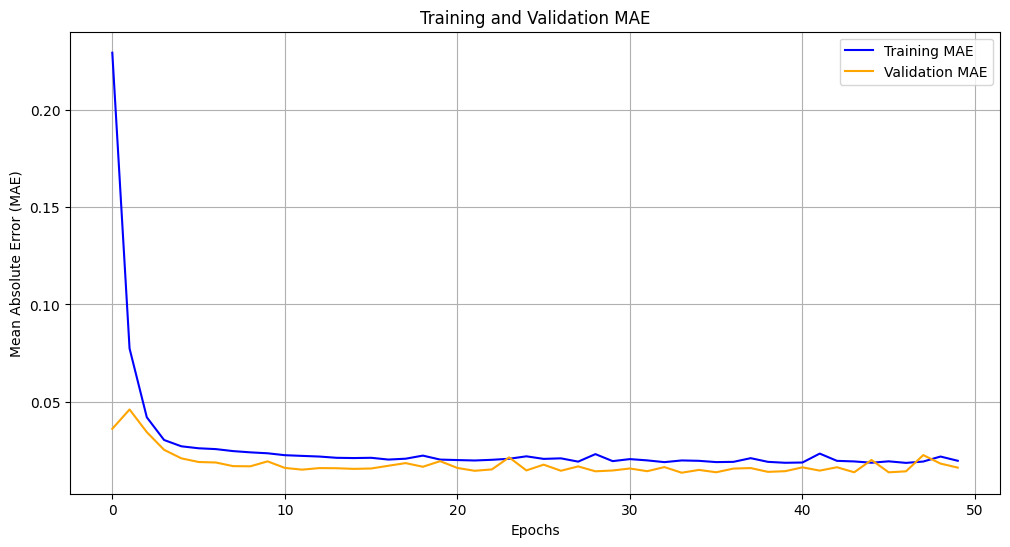

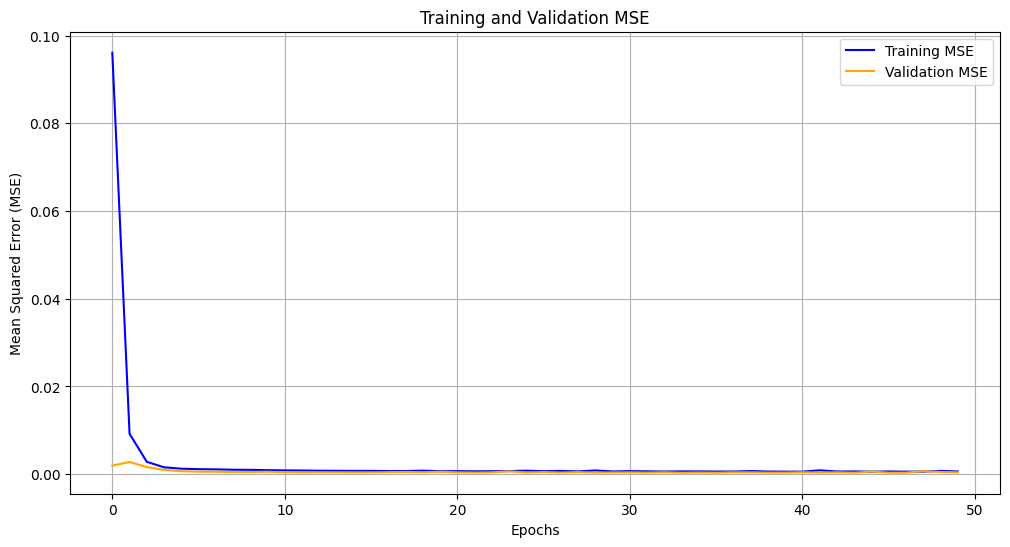

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.001
R^2 Score: 0.885
Mean Absolute Percentage Error (MAPE): 12.589%


In [100]:
history = cl_base_history.history
train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = cl_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
cl_base_metric =  print_evaluation_metrics(y_true, y_pred)

### 6.3 Hyper-tune model

In [101]:
# Define LSTM-CNN Model with hyper-tuning for the number of layers
def build_lstm_cnn_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
    
    for i in range(hp.Int('num_cnn_layers', 1, 2)):
        model.add(layers.Conv1D(
            filters=hp.Int(f'cnn_filters_{i}', min_value=50, max_value=100, step=25),
            kernel_size=hp.Choice(f'cnn_kernel_size_{i}', values=[1, 2]),
            activation='relu'
        ))
    
    # Hyper-tuning number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 2)):
        model.add(layers.LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=64, step=8),
            return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False
        ))
        model.add(layers.Dropout(hp.Float('dropout_rate', 0.1, 0.2, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

# Hyperband tuner
tuner = kt.Hyperband(
    build_lstm_cnn_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='nn_cache',
    project_name='lstm_cnn'
)

# Run Hyperband tuning
tuner.search(train_feature_seq, train_target_seq, validation_data=(validation_feature_seq, validation_target_seq), epochs=50, batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/lstm_cnn/tuner0.json


In [102]:
lc_model = tuner.hypermodel.build(best_hps)
lc_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
lc_history = lc_model.fit(
    train_feature_seq, train_target_seq,
    epochs=200,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2476 - mae: 0.2476 - mse: 0.1130 - val_loss: 0.0331 - val_mae: 0.0331 - val_mse: 0.0014
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0555 - mae: 0.0555 - mse: 0.0050 - val_loss: 0.0199 - val_mae: 0.0199 - val_mse: 5.8159e-04
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0527 - mae: 0.0527 - mse: 0.0045 - val_loss: 0.0229 - val_mae: 0.0229 - val_mse: 7.2321e-04
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460 - mae: 0.0460 - mse: 0.0033 - val_loss: 0.0136 - val_mae: 0.0136 - val_mse: 3.2068e-04
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471 - mae: 0.0471 - mse: 0.0036 - val_loss: 0.0202 - val_mae: 0.0202 - val_mse: 6.1340e-04
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471 - mae: 0.0471 - mse: 0.0035 - val_loss: 0.0220 - val_mae: 0.0220 - val_mse: 6.6202e-04
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0493 - mae: 0.0493 - mse:

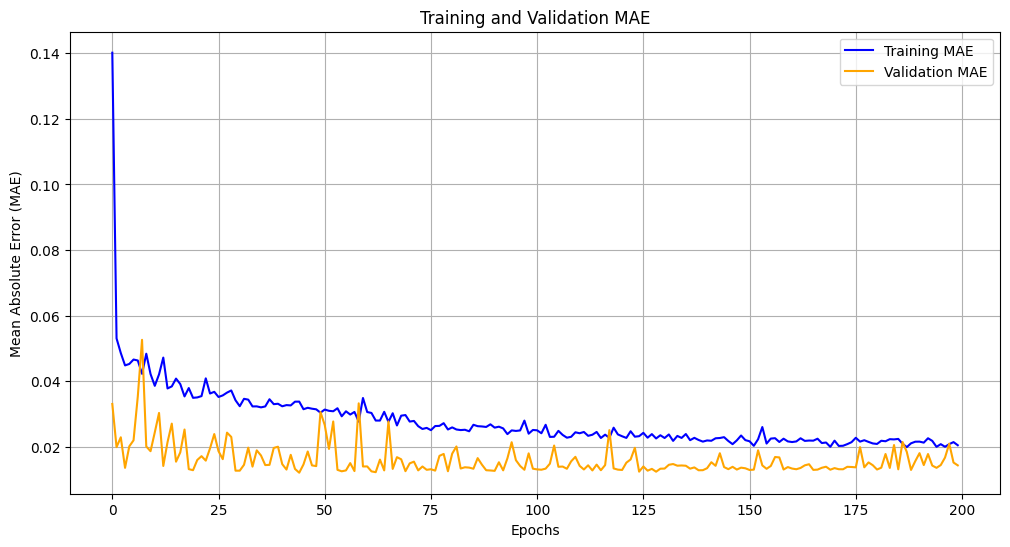

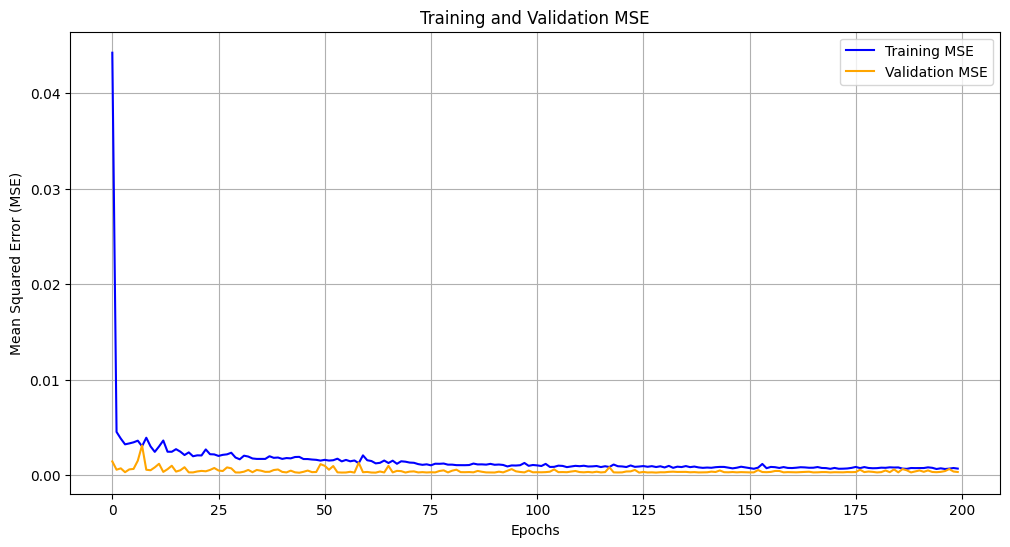

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Absolute Error (MAE): 0.015
Mean Squared Error (MSE): 0.000
R^2 Score: 0.898
Mean Absolute Percentage Error (MAPE): 12.455%


In [103]:
def evaluate_model(history, model, test_features, test_target):
	# Extract training and validation metrics
	train_mae, train_mse = history['mae'], history['mse']
	validate_mae, validate_mse = history['val_mae'], history['val_mse']

	# Plot the training and validation MAE and MSE
	plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
	plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

	# Get model predictions on Test Data
	y_pred = model.predict(test_features)
	y_true = pd.DataFrame(test_target)

	# Print Evaluation Metrics
	metric  = print_evaluation_metrics(y_true, y_pred)

	return metric, y_pred

lc_metric, y_pred =  evaluate_model(lc_history.history, lc_model, test_feature_seq, test_target_seq)
lc_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


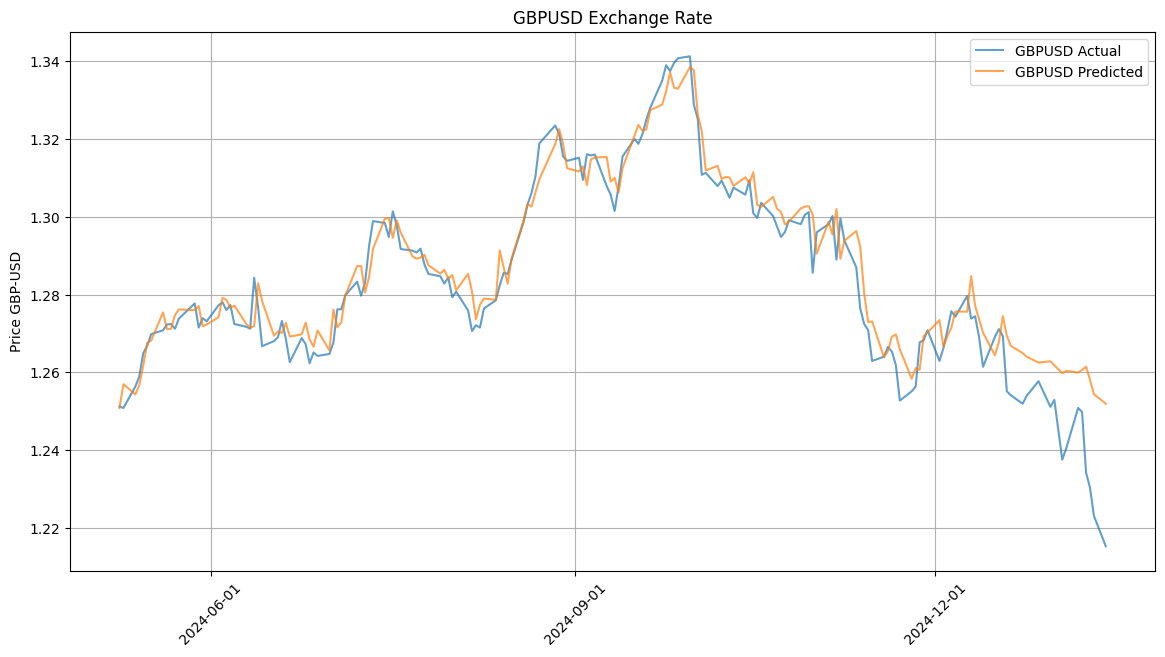

In [104]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

lc_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# Plot all metrics in a single table

In [105]:
metrics = [dnn_metric, lstm_metric, rnn_metric, lc_metric]  

df = pd.DataFrame()
# Initialize the DataFrame with appropriate columns
df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R Square', 'MAPE'])

# Populate the DataFrame with metrics
for i, m in enumerate(metrics):
	df = pd.concat([df, pd.DataFrame([{
		'Model': f'Model {i + 1}',
		'MAE': m['MAE'],
		'MSE': m['MSE'],
		'R Square': m['R Square'],
		'MAPE': m['MAPE']
	}])], ignore_index=True)

df
        

/var/folders/xz/1gn0m18n5k1bjmbt205k50cm0000gn/T/ipykernel_45343/999570319.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


,Model,MAE,MSE,R Square,MAPE
0,Model 1,0.011171,0.000571,0.885698,2.130132
1,Model 2,0.016178,0.000530,0.890983,12.517582
2,Model 3,0.015541,0.000397,0.918349,12.356393
3,Model 4,0.015032,0.000495,0.898164,12.454818


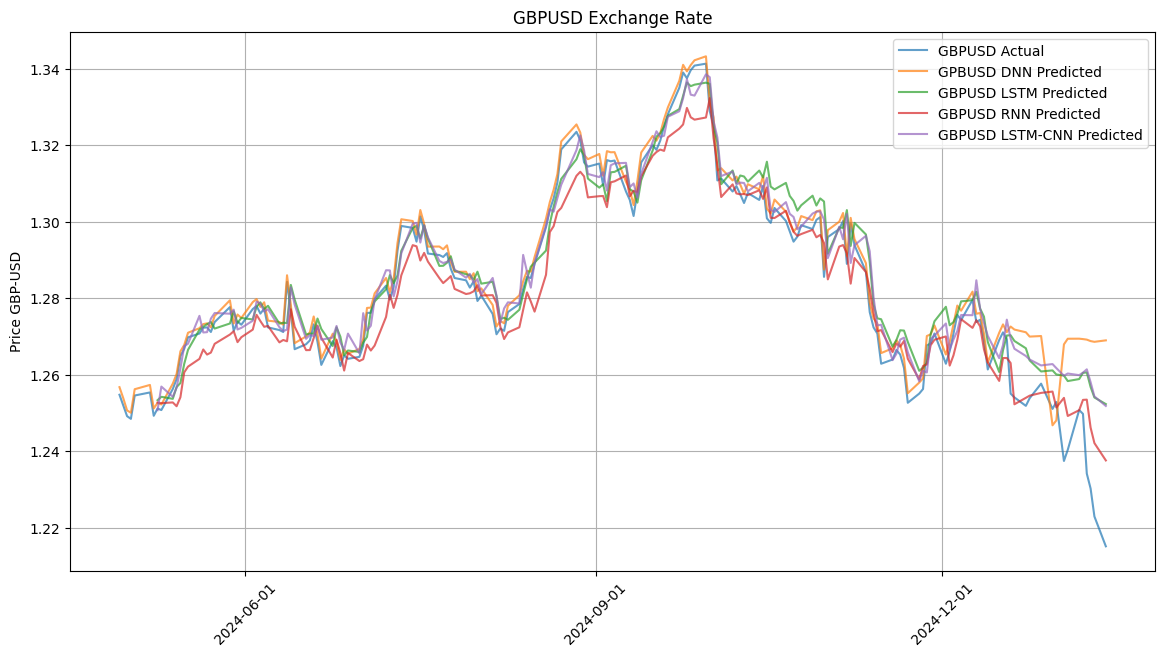

In [106]:
dnn_features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']

plot_gbp_usd([
	[test['Date'], u_test['Open'], "GBPUSD Actual"],
	[test['Date'], dnn_predicted, "GPBUSD DNN Predicted"],
	[test['Date'][7:], lstm_pred, "GBPUSD LSTM Predicted"],
	[test['Date'][7:], rnn_pred, "GBPUSD RNN Predicted"],
	[test['Date'][7:], lc_pred, "GBPUSD LSTM-CNN Predicted"],
])
